In [52]:
%matplotlib inline
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# load pretrained model
from torchvision import models

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use

In [53]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        #for img in self.image_paths:
        #    print((os.path.split(img)))
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        # fetch folder name as the class type
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something else than $128\times128$ images.

**TODO lists:** add by xiaohu
    1. what is the proper size for this specific task? for vgg16, batchsize have to be a small number in order not to make memory leak.
    2. data augmentation - zhao.
    3. modify batchSize: 64 - other nets, 32-vgg16. - wu.
    4. input normalization - zhao.

**NOTE**
* if you use ssh, please choose useLocal = False
* if you don't use pretrained model, choose useVGG = False

In [54]:
useVGG = True
useLocal = True

if useVGG ==True:
    size = 224
    train_transform = transforms.Compose([transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    test_transform = transforms.Compose([transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
else:
    # TODO-1,2: what is the proper size for this specific task?
    size = 128
    train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                        transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                        transforms.ToTensor()])
    
if useLocal == True:
    datapath = '../hotdog_nothotdog'
else:
    datapath = '/scratch/hotdog_nothotdog'

# TODO-3: what is the proper batchSize? 100
batch_size = 32
trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path=datapath)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path=datapath)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

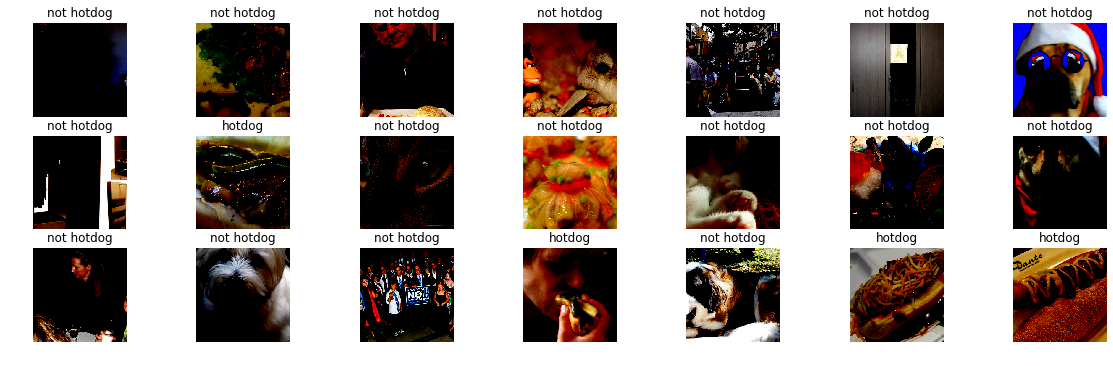

In [55]:
images, labels = next(iter(train_loader))
print(labels.shape)
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    #print(labels[i].item())
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

CNN design: by xiaohu
1. try a net like VGG; best 81%.
2. try network in network; best 79%.
3. try ResNet; 76%.
4. use pretrained vgg16. 89%.

So vgg16 is the winner.

TODO:
1. ~~add batchNormalization;~~ done by xiaohu.
2. SGD, SGD+Momentum, ~~Adam~~; - wu.
3. early stopping; 

In [16]:
class Network(nn.Module):
    '''
    the first net is inspired by VGG-16.
    '''
    def __init__(self):
        super(Network, self).__init__()
        #...
        self.convolutional = nn.Sequential(
            ## input is 3x128x128
            # layer-1, 64x3x128x128
            nn.Conv2d(3,64,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-2, 64x64x128x128
            nn.Conv2d(64,64,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # pooling, 64x64x64
            nn.MaxPool2d(2,stride=2),
            # layer-3, 128x64x64x64
            nn.Conv2d(64,128,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-4, 128x128x64x64
            nn.Conv2d(128,128,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # pooling, 128x32x32
            nn.MaxPool2d(2,stride=2),
            # layer-5, 256x128x32x32
            nn.Conv2d(128,256,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-6, 256x256x32x32
            nn.Conv2d(256,256,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # pooling, 256x16x16
            nn.MaxPool2d(2,stride=2),
            # layer-7, 512x16x16
            nn.Conv2d(256,512,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-8, 512x16x16
            nn.Conv2d(512,512,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # pooling, 512x8x8
            nn.MaxPool2d(2,stride=2),
            # layer-9, 512x8x8
            nn.Conv2d(512,512,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-10, 512x8x8
            nn.Conv2d(512,512,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # pooling, 512x4x4
            nn.MaxPool2d(2,stride=2)
        )
        
        self.fully_connected = nn.Sequential(
                nn.Linear(512*4*4, 100),
                nn.ReLU(),
                #nn.Linear(4096, 1000),
                #nn.ReLU(),
                nn.Linear(100,2)
                #nn.Softmax(dim=1)
        )
    def forward(self, x):
        # ...
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        
        return x

In [17]:
class NetInNet(nn.Module):
    '''
    This net is inspired by Network-in-Network which cascades a MLP with a normal conv2D 
    before doing max pooling.
    '''
    def __init__(self):
        super(NetInNet, self).__init__()
        # self designed network achitexture
        self.conv = nn.Sequential(
            # input is 3x128x128
            nn.Conv2d(3,64,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),#32x128x128
            nn.Conv2d(64,32,1,stride=1),
            nn.ReLU(),#16x128x128
            nn.Conv2d(32,16,1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),# 16x64x64
            #nn.Dropout(),
            
            # 16x64x64
            nn.Conv2d(16,128,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,64,1,stride=1),
            nn.ReLU(),
            nn.Conv2d(64,32,1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),# 32x32x32
            #nn.Dropout(),
            
            # 16x32x32
            nn.Conv2d(32,256,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,64,1,stride=1),
            nn.ReLU(),
            nn.Conv2d(64,16,1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),# 16x16x16
            nn.Dropout()
        )
        
        self.fn = nn.Sequential(
            nn.Linear(16*16*16,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,2)
            #nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.fn(x)
        
        return x

In [18]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        # ...
        self.resblock = nn.Sequential(
            nn.Conv2d(n_features,n_features,kernel_size=3,
                      stride=1,padding=(1,1),bias=False),
            nn.BatchNorm2d(n_features),
            nn.ReLU(),
            nn.Conv2d(n_features,n_features,kernel_size=3,stride=1,padding=(1,1),bias=False),
            nn.BatchNorm2d(n_features)
        )
    
    def forward(self, x):
        # ...
        out = self.resblock(x)
        out += x
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=5, sz = 128):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features[0], kernel_size=7, stride=2, padding=3),
                       nn.ReLU()]
        conv_layers.append(nn.BatchNorm2d(n_features[0]))
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.MaxPool2d(2,stride=2))
        # max pooling
        sz = sz // 4
        
        for j in range(1,len(n_features)):
            conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(n_features[j-1], 
                              n_features[j], 3, stride=2,padding=1), 
                    nn.ReLU()))
            for i in range(num_res_blocks):
                conv_layers.append(ResNetBlock(n_features[j]))
            sz = sz // 2
        
        conv_layers.append(nn.AvgPool2d(4, stride=1))
        
        #print('j:%s, len:%s'%(j,len(n_features)))
            
        # last
        #for i in range(num_res_blocks):
        #        conv_layers.append(ResNetBlock(n_features[j]))
        
        # conv_layers.append(nn.MaxPool2d(2,stride=2))
        # sz = sz//2
        #print(sz)
        
        self.res_blocks = nn.Sequential(*conv_layers)
        
        self.fc = nn.Sequential(nn.Linear(n_features[-1], 2, bias=False)
                                #nn.ReLU(),
                                #nn.Linear(1000,2),
                                #nn.Softmax(dim=1)
                               )
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

training part

In [19]:
if useVGG == True:
    model = models.vgg16(pretrained=True)
else:
    # if use VGG-like, comment this
    model = Network()
    # if use NiN, comment this
    #model = NetInNet()
    # if use ResNet-like, comment this
    #model = ResNet(3,[64,128,256,512],1,128)

# display model 
# print(model)

if useVGG == True:
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.avgpool.parameters():
        param.requires_grad = False
    myClassifier = []
    
    useBN = True
    if useBN == True:
        model.classifier=nn.Sequential(
            nn.Linear(25088, 4096, bias=True),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096, bias=True),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2, bias=True),
        )
    else:
        for i in range(len(model.classifier)-1):
            myClassifier.append(model.classifier[i])
        myClassifier.append(nn.Linear(4096,2))
        model.classifier = nn.Sequential(*myClassifier)

# print(model)

# check if freeze works
for param in model.parameters():
    if param.requires_grad == True:
        print(param.shape)

torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([2, 4096])
torch.Size([2])


In [20]:
# check if GPU exsit
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

The code will run on GPU. This is important so things run faster.


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [21]:
#Initialize the optimizer with model parameters that need to be retrained

# optimizer = torch.optim.SGD(filter(lambda param: param.requires_grad, model.parameters()),
#                             lr=1e-2,momentum=0.9)# fine tuning
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()),
                             lr=1e-3)

In [22]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    train_acc_all = []
    test_acc_all = []

    cost = torch.nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            #loss = F.nll_loss(torch.log(output), target)## what does nll_loss mean
            #Use cross-entropy as cost function 
            loss = cost(output, target)
            
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        
        #Comput the test accuracy
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target==predicted).sum().item()
        train_acc = train_correct/len(trainset)
        test_acc = test_correct/len(testset)
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    return test_acc_all, train_acc_all

In [23]:
#optimizer = torch.optim.SGD(filter(lambda param: param.requires_grad, model.parameters()), lr=1e-2,momentum=0.9)# fine tuning
test_acc, train_acc = train(model, optimizer, 5)# training

Accuracy train: 86.0%	 test: 90.3%


Accuracy train: 97.9%	 test: 88.6%


Accuracy train: 98.6%	 test: 89.8%


Accuracy train: 99.1%	 test: 87.7%


Accuracy train: 99.2%	 test: 88.4%



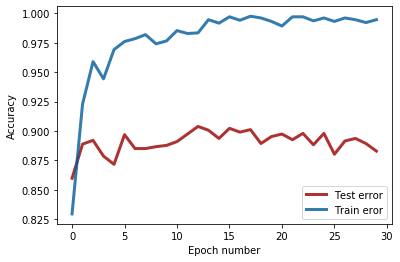

In [51]:
fig,ax = plt.subplots()
ax.plot(test_acc,c='#990000',alpha=0.8,linewidth=3,label='test_acc')
ax.plot(train_acc,c='#005b99',alpha=0.8,linewidth=3,label='train_acc')
# ...
ax.legend(('Test error','Train eror'))
ax.set(xlabel='Epoch number')
ax.set(ylabel='Accuracy')
plt.savefig('./figures/vgg16.png',dpi=300)

In [56]:
modelname = 'vgg16-hotdog.tar'
if useLocal == True:
    dirname = '../model/'
else:
    dirname = './model/'

torch.save(model, dirname+modelname)

In [ ]:
# test model
#trained_model = torch.load('./model/vgg-like-hotdog.tar')
trained_model = torch.load(dirname+modelname)

print(dirname+modelname)

print(trained_model)

device = torch.device('cpu')
trained_model.to(device)

test_correct = 0
trained_model.eval()
for data, target in test_loader:
    data = data.to(device)
    with torch.no_grad():
        output = trained_model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().cpu().item()
test_acc = test_correct/len(testset)
print('Test Accuracy:%s'%test_acc)

ok, the first model achieves 78.4% accuracy. From the loss curve, it seems the model is over-fitted. the maximum accuracy could be 81%.

nin model with fine tuning is able to achieve 79.2%.